In [1]:
import os

In [2]:
os.chdir('StyleCLIP/')

In [3]:
import argparse
import math

import librosa
import torch
import torchvision
from torch import optim
from tqdm import tqdm

from criteria.clip_loss import CLIPLoss
from criteria.id_loss import IDLoss
from criteria.aclip_loss import CLIPLossAudio, CLIPLossImage
from mapper.training.train_utils import STYLESPACE_DIMENSIONS
from models.stylegan2.model import Generator
import clip
from utils import ensure_checkpoint_exists

In [11]:
class opts:
    stylegan_size = 1024
    ckpt =  "/data/scratch/ngop/StyleWav/StyleCLIP/stylegan2-ffhq-config-f.pt"
    lr_rampup= 0.05
    lr= 0.1
    work_in_stylespace= "stylespace"
    truncation= 0.7
    ir_se50_weights= "/data/scratch/ngop/StyleWav/StyleCLIP/model_ir_se50.pth"
    audio=None
    aclip_loss= False

In [12]:
param = opts()

In [13]:
clip_loss = CLIPLoss(param)

In [14]:
aclip_image_clip_loss = CLIPLossImage(param)

In [19]:
latent_code_init = mean_latent.detach().clone().repeat(1, 18, 1)
latent = latent_code_init.detach().clone()
latent.requires_grad = True

In [20]:
g_ema = Generator(param.stylegan_size, 512, 8)
g_ema.load_state_dict(torch.load(param.ckpt)["g_ema"], strict=False)
g_ema.eval()
g_ema = g_ema.cuda()
mean_latent = g_ema.mean_latent(4096)

In [42]:
img_gen, _ = g_ema([latent], input_is_latent=True, randomize_noise=False, input_is_stylespace=False)

In [43]:
import matplotlib.pyplot as plt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


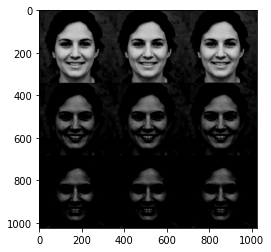

In [44]:
plt.imshow(img_gen.detach().cpu().reshape(1024, 1024, 3))

In [45]:
prompt = torch.cat([clip.tokenize("hey")]).cuda()
prompt

tensor([[49406,  2189, 49407,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], device='cuda:0')

In [35]:
clip_loss(img_gen, prompt)

tensor([[0.7988]], device='cuda:0', dtype=torch.float16,
       grad_fn=<RsubBackward1>)

In [36]:
aclip_image_clip_loss(img_gen, prompt)

tensor([[0.9712]], device='cuda:0', dtype=torch.float16,
       grad_fn=<RsubBackward1>)

In [37]:
model, preprocess = clip.load("ViT-B/32", device="cuda")
upsample = torch.nn.Upsample(scale_factor=7)
avg_pool = torch.nn.AvgPool2d(kernel_size=param.stylegan_size // 32)

In [48]:
#CLIP LOSS

image = avg_pool(upsample(img_gen))
similarity = 1 - model(image, prompt)[0] / 100

print(model(image, prompt)[0])

tensor([[20.1562]], device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward>)


In [54]:
import numpy as np

In [58]:
logit_scale = torch.nn.Parameter(torch.ones([]) * np.log(1 / 0.07))

image = avg_pool(upsample(img_gen))
image_features = model.encode_image(image)

text_features =  model.encode_text(prompt)

image_features = image_features / image_features.norm(dim=-1, keepdim=True)
text_features = text_features / text_features.norm(dim=-1, keepdim=True)

# cosine similarity as logits
logit_scale = model.logit_scale.exp()
logits_per_image = logit_scale * image_features @ text_features.t()
logits_per_text = logit_scale * text_features @ image_features.t()

print(logits_per_image)

similarity = 1 - logits_per_image / 100

tensor([[20.1562]], device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward>)


In [56]:
print(model.logit_scale)

Parameter containing:
tensor(4.6052, device='cuda:0', requires_grad=True)


In [57]:
print(logit_scale.exp())

tensor(1600320., grad_fn=<ExpBackward>)
